Preparing Text Data for use with Retrieval Augmented LLMs


In [1]:
!pip install -qU langchain tiktoken matplotlib seaborn tqdm

In [ ]:
#Preparing Data
#We will use docs page of the james webb space telescope


!wget -r -A.html -P rtdocs https://python.readthedocs.io/en/latest/ 

In [1]:
from langchain.document_loaders import ReadTheDocsLoader

loader = ReadTheDocsLoader('rtdocs')
docs = loader.load()
len(docs)

/home/susearc/gamedisk/stable-torch/lib/python3.9/site-packages/langchain/document_loaders/readthedocs.py:48: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 48 of the file /home/susearc/gamedisk/stable-torch/lib/python3.9/site-packages/langchain/document_loaders/readthedocs.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  _ = BeautifulSoup(
/home/susearc/gamedisk/stable-torch/lib/python3.9/site-packages/langchain/document_loaders/readthedocs.py:75: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code

500

In [6]:
docs[30].page_content

# Clearly the pages have different annotations and values to modify

'Index – Q\nqiflush() (in module curses)\nQName (class in xml.etree.ElementTree)\nqsize() (asyncio.Queue method)\n(multiprocessing.Queue method)\n(queue.Queue method)\nqualified name\nquantize() (decimal.Context method)\n(decimal.Decimal method)\nQueryInfoKey() (in module winreg)\nQueryReflectionKey() (in module winreg)\nQueryValue() (in module winreg)\nQueryValueEx() (in module winreg)\nQueue (class in asyncio)\n(class in multiprocessing)\n(class in queue)\nqueue (module)\n(sched.scheduler attribute)\nQueue() (multiprocessing.managers.SyncManager method)\nQueueEmpty\nQueueFull\nQueueHandler (class in logging.handlers)\nQueueListener (class in logging.handlers)\nquick_ratio() (difflib.SequenceMatcher method)\nquit (built-in variable)\n(pdb command)\nquit() (ftplib.FTP method)\n(nntplib.NNTP method)\n(poplib.POP3 method)\n(smtplib.SMTP method)\nquopri (module)\nquote() (in module email.utils)\n(in module shlex)\n(in module urllib.parse)\nQUOTE_ALL (in module csv)\nquote_from_bytes() (in

In [8]:
# We can also find the source of each document:

docs[15].metadata['source'].replace('rtdocs/', 'https://')

'https://python.readthedocs.io/en/latest/genindex-B.html'

In [2]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')


# Create the length function

def tiktoken_len(text):
    tokens = tokenizer.encode(text=text,disallowed_special=())
    return len(tokens)

In [3]:
#also to find the encodings
tiktoken.encoding_for_model('gpt-3.5-turbo')

<Encoding 'cl100k_base'>

In [4]:
token_counts = [tiktoken_len(doc.page_content) for doc in docs]

In [5]:
print(f"""{min(token_counts)}
AVG: {int(sum(token_counts)/len(token_counts))}
Max: {max(token_counts)}""")

0
AVG: 4028
Max: 93472


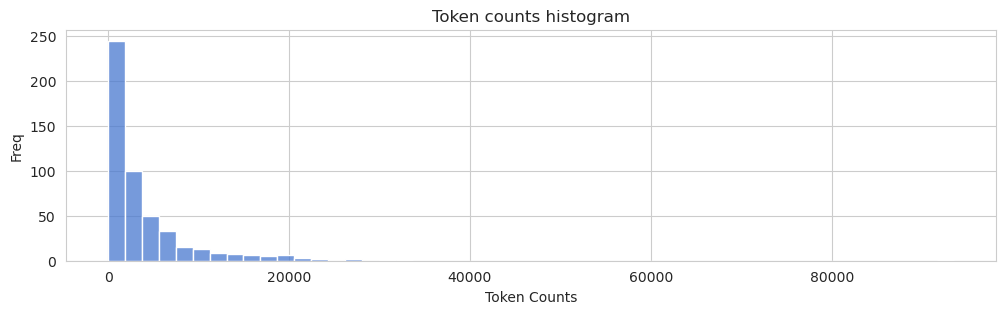

In [6]:
#Now visualize

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("muted")


plt.figure(figsize=(12,3))
sns.histplot(token_counts,kde=False, bins=50)


plt.title("Token counts histogram")
plt.xlabel("Token Counts")
plt.ylabel("Freq")


plt.show()

## Chunking the Text

In [7]:
# At the time of writing gpt3.5turbo supports a context window of 4096 tokens --- that means that input tokens + generated tokens can be at most 4096 tokens long.

# Lets assume we take 2000 tokens for the input prompt and 2000 tokens for converstation history and completion

from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 400,
    chunk_overlap = 20,
    length_function = tiktoken_len,
    separators=['\n\n','\n',' ','']
)

In [14]:
chunks = text_splitter.split_text(docs[52].page_content)
len(chunks)

75

In [19]:
chunks_sizes = [tiktoken_len(chunk) for chunk in chunks]

<Axes: ylabel='Count'>

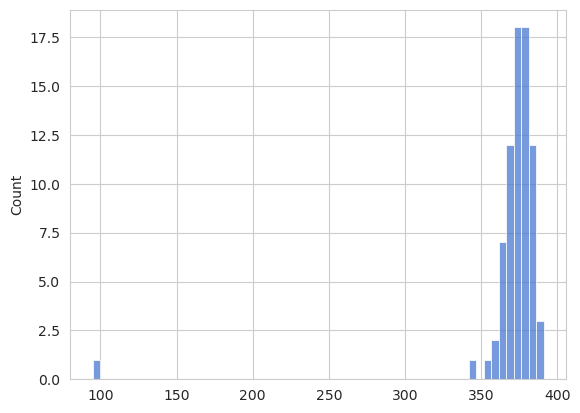

In [21]:

sns.histplot(chunks_sizes)


## This is the format we need to create
```json
[
    {
        "id": "abc-0",
        "text": "some important document text",
        "source": "https://langchain.readthedocs.io/en/latest/glossary.html"
    },
    {
        "id": "abc-1",
        "text": "the next chunk of important document text",
        "source": "https://langchain.readthedocs.io/en/latest/glossary.html"
    }
    ...
]
```

In [25]:
import hashlib
m = hashlib.md5()

In [27]:
url = docs[5].metadata['source'].replace('rtdocs/', 'https://')

In [29]:
# convert URL to unique ID
m.update(url.encode('utf-8'))
uid = m.hexdigest()[:12]
print(uid)

a7ec8950d8c9


In [ ]:
data = [
    {
        'id': f'{uid} - {i}',
        'text': chunk[10:100],
        'source': url
    } for i, chunk in enumerate(chunks)
]

data

In [40]:
#repeat across the whole dataset

from tqdm.auto import tqdm

documents = []

for doc in tqdm(docs):
    url = doc.metadata['source'].replace('rtdocs/', 'https://')
    m.update(url.encode('utf-8'))
    uid = m.hexdigest()[:12]
    chunks = text_splitter.split_text(doc.page_content)
    for i, chunk in enumerate(chunks):
        documents.append({
            'id': f'{uid}-{i}',
            'text': chunk,
            'source': url
        })

  0%|          | 0/500 [00:00<?, ?it/s]

In [41]:
len(documents)

5765

In [39]:
#save them in a json file
import json
with open('train.json','w+') as f:
    for doc in documents:
        f.write(json.dumps(doc) + '\n')